# **Large Language Model for Hydrogen Storage [Question-Answering]**

# Model Architecture

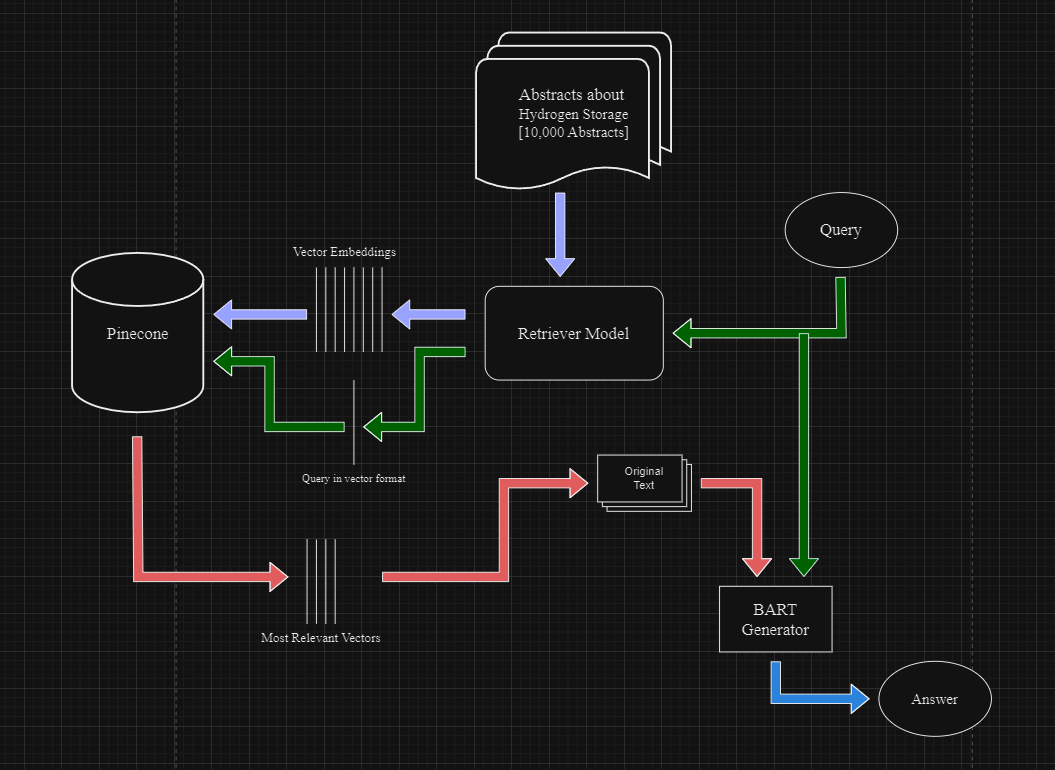

In [ ]:
!pip install -qU datasets pinecone-client==3.1.0 sentence-transformers torch

# **Loading Dataset**

In [ ]:
df = pd.read_csv("hydroQ&A.csv")
df.head()

,Link,Abstract
0,https://www.scopus.com/inward/record.uri?eid=2...,Highly developed porous materials are urgently...
1,https://www.scopus.com/inward/record.uri?eid=2...,The urgent need to address climate issues incr...
2,https://www.scopus.com/inward/record.uri?eid=2...,The Li-Mg-B-H composite (2LiBH4 + MgH2) is ack...
3,https://www.scopus.com/inward/record.uri?eid=2...,A hydrogen compressed air energy storage power...
4,https://www.scopus.com/inward/record.uri?eid=2...,Supercritical cryogenic fluids are widely used...


In [ ]:
df = df.drop("Link", axis = 1)

In [ ]:
df

,Abstract
0,Highly developed porous materials are urgently...
1,The urgent need to address climate issues incr...
2,The Li-Mg-B-H composite (2LiBH4 + MgH2) is ack...
3,A hydrogen compressed air energy storage power...
4,Supercritical cryogenic fluids are widely used...
...,...
9995,Anisotropic etching silicon (Si) is an active ...
9996,Toward carbon peaking and carbon neutrality go...
9997,"As an energy carrier, it has a long history. A..."
9998,Hydrogen needs to be transported and distribut...


In [ ]:
df.shape

(10000, 1)



---



---



# **Initializing Pinecone Index**

In [ ]:
import os
from pinecone import Pinecone

# Set the API key directly in the code
api_key = 'ebdeef51-da66-4b97-9902-6feffc6a890c'

# Initialize the Pinecone client using the API key
pc = Pinecone(api_key=api_key)

In [ ]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [ ]:
index_name = "hydro-question-answering"

In [ ]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=768,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}



---



---



# **Initializing Retriever Model**

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the retriever model from huggingface model hub
retriever = SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)
retriever

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)



---



---



# **Generate Embeddings**

In [ ]:
# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(df))
    # extract batch
    batch = df.iloc[i:i_end]
    # generate embeddings for batch
    emb = retriever.encode(batch["Abstract"].tolist()).tolist()
    # get metadata
    meta = batch.to_dict(orient="records")
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# check that we have all vectors in index
index.describe_index_stats()

  0%|          | 0/157 [00:00<?, ?it/s]

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 18320}},
 'total_vector_count': 18320}



---



---



# **Initialize Generator**

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# load bart tokenizer and model from huggingface
tokenizer = BartTokenizer.from_pretrained('vblagoje/bart_lfqa')
generator = BartForConditionalGeneration.from_pretrained('vblagoje/bart_lfqa').to(device)

In [ ]:
def query_pinecone(query, top_k):
    # generate embeddings for the query
    xq = retriever.encode([query]).tolist()
    # search pinecone index for context passage with the answer
    xc = index.query(vector=xq, top_k=top_k, include_metadata=True)
    return xc

In [ ]:
def format_query(query, context):
    # extract Abstract from Pinecone search result and add the <P> tag
    context = [f"<P> {m['metadata']['Abstract']}" for m in context]

    context = " ".join(context)

    query = f"question: {query} context: {context}"
    return query

In [ ]:
query = "what is hydrogen storage?"

# Obtaining Abstracts with releveant information related to the topic
result = query_pinecone(query, top_k=1)
result

{'matches': [{'id': '9967',
              'metadata': {'Abstract': 'Hydrogen energy is regarded as the '
                                       'clean energy with the most development '
                                       'potential. In order to realize the '
                                       'large-scale application of hydrogen '
                                       'energy, the problem of hydrogen '
                                       'storage must be solved. At present, '
                                       'there are three main ways of hydrogen '
                                       'storage, namely compressed hydrogen '
                                       'storage, liquid hydrogen storage, and '
                                       'solid-state hydrogen storage. '
                                       'Compressed hydrogen storage is the '
                                       'most commonly used hydrogen storage '
                                       'me

In [ ]:
def generate_answer(query):
    # tokenize the query to get input_ids
    inputs = tokenizer([query], max_length=1024, return_tensors="pt").to(device)
    # use generator to predict output ids
    ids = generator.generate(inputs["input_ids"], num_beams=2, min_length=20, max_length=60)
    # use tokenizer to decode the output ids
    answer = tokenizer.batch_decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    return print(answer)

In [ ]:
def qa_generate(question):
  context = query_pinecone(question, top_k=10)
  question = format_query(question, context["matches"])
  answer = generate_answer(question)
  return answer

# **Testing**

In [ ]:
query1 = "what are the different methods of hydrogen storage?"
context = query_pinecone(query1, top_k=10)
query1 = format_query(query1, context["matches"])
generate_answer(query1)

There are three main methods of hydrogen storage: compressed hydrogen, liquid hydrogen, and solid hydrogen. The first two are the most common, but the third is the most promising. Compressed hydrogen storage is the most commonly used hydrogen storage method.


In [ ]:
qa_generate(query1)

There are three main ways to store hydrogen. The first is to compress the hydrogen gas to a very low pressure. The second is to liquefy the hydrogen gas. The third is to store the hydrogen as a liquid in a container.




---



In [ ]:
query2 = "why are metal hydrides important in hydrogen storage?"
context = query_pinecone(query2, top_k=5)
query2 = format_query(query2, context["matches"])
generate_answer(query2)

Metal hydrides are a good choice for storing hydrogen because they have a very low melting point. This means that they can be stored in a very small volume, and they can be stored at a very low temperature. This means that they can be stored in a very small space, and


In [ ]:
qa_generate(query2)

Metal hydrides are a good choice for storing hydrogen because they have a very low melting point. This means that they can be stored in a very small volume, and they can be stored at a very low temperature. This means that they can be stored in a very small volume, and




---



In [ ]:
query3 = "what is hydrogen?"
context = query_pinecone(query3, top_k=10)
query3 = format_query(query3, context["matches"])
generate_answer(query3)

Hydrogen is the most abundant element in the universe. It is also the most abundant element in the atmosphere. It is also the most abundant element in the universe, but it is not found as a free molecule in the atmosphere. It is found in many chemicals around us, from water and




---



---

